In [18]:
from skimage.morphology import skeletonize, thin, binary_erosion
from scipy.interpolate import lagrange, CubicSpline
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import imageio
from scipy import misc
from skimage import color
from skimage import measure
import sys

#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as plx

np.set_printoptions(threshold=sys.maxsize, linewidth=1000)

## PRE-PROCESSING AND EDA

In [117]:
"""
Tommy's Utility Functions for converting images from color to black and white.
"""

FIGURE_SIZE = (7, 6)
def make_bw(img,thresh=130):
    # Converts from color to bw/binary image
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img

def bw_convert(img,thresh):
    # Converts the grayscale to a simple black-white: that may help us in observing the 
    # "Fractal" structure (and other formal qualities)
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    return bw_pic


(335, 332, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True False  True  True  True  True  True  True  True  True  

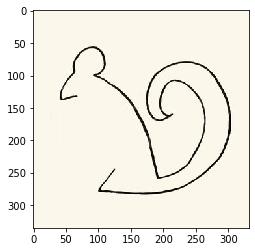

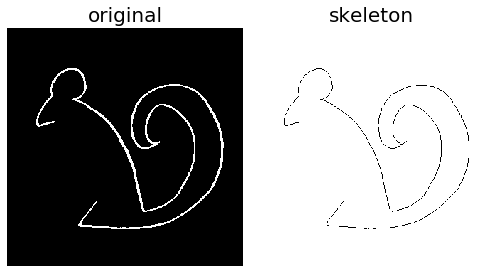

In [118]:
# Invert the squirrel image
squirrel = imageio.imread('images/squirrel.jpg') 
print(squirrel.shape)
plt.imshow(squirrel)

squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=FIGURE_SIZE,
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(squirrel_bw, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)
print(skeleton[150])

fig.tight_layout()
plt.show()

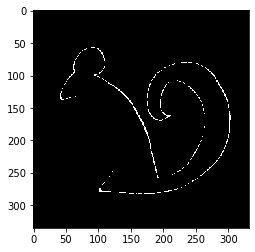

In [4]:
inverted_image = invert(make_bw(squirrel))
eroded_image = binary_erosion(inverted_image)

plt.imshow(eroded_image, cmap=plt.cm.gray)

Neither erosion nor skeleton produces a nice continuous set of points; we'll have to go another route. We ultimately landed on using contours, and grabbing the "correct" 50% constituting one line.

This is a fairly manual process that mostly comprised of "guessing and checking", and in future iterations, we'd like to find a more elegant / automated solution to this.

(1, 3177, 2)


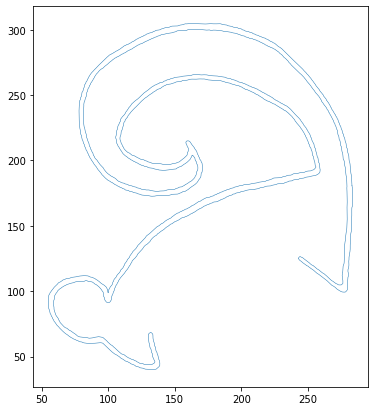

In [122]:
initial_image = imageio.imread("images/squirrel.jpg")
gray_scale_image = color.colorconv.rgb2grey(initial_image)
contours = measure.find_contours(gray_scale_image, 0.8)
# Now cast it to an NP array so it's more workable.
contours = np.array(contours)
print(contours.shape)

contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.figure(figsize=(6, 7))
plt.plot(xs, ys,  linewidth=0.5)
plt.show()


def rotate_points(coordinate_pair):
    """
    Rotates the image reverse -90 degrees.
    """ 
    rotation_matrix = np.array([
        [0, 1],
        [-1, 0]
    ])
    result = np.matmul(rotation_matrix, coordinate_pair)
    return result

def translate_y(coordinate_pair):
    # TODO: these numbers are super hard-coded --- there's probably a simple way to make
    # This more programmatic by picking the most negative Y if there are negatives and 
    # translating it; And if all Y's are positive, bring them down
    result = [coordinate_pair[0], coordinate_pair[1] + 300]
    return result

# Do a reverse 90-degree matrix transformation on the points to rotate the image
contours = np.array([[rotate_points(cp) for cp in contours[0]]])
# And now move the points upwards by adding 300 to each point 
contours = np.array([[translate_y(cp) for cp in contours[0]]])

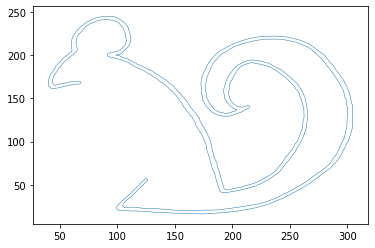

In [7]:
# Image once after the above matrix transformations have been applied:
contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.plot(xs, ys,  linewidth=0.5)

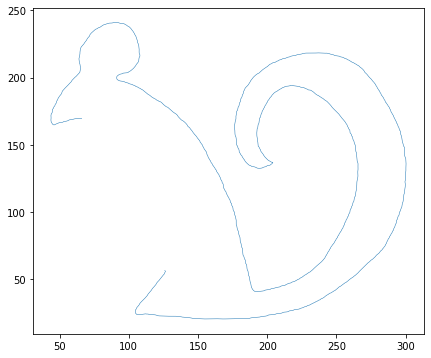

In [8]:
# Now, we must find the approximate 50% of the image to generate just one line; 
# since the vector starts and ends at the same point. This is a deeply manual process, 
# and if we had the extra time, perhaps we could find a way to automate this.
row_start = 1465
row_end = 3025

# Now, we can plot the image
# TODO: Get a figure at the normal size
plt.figure(figsize=(7, 6))

contour = contours[0]
xs = contour[row_start:row_end, 0]
ys = contour[row_start:row_end, 1]
plt.plot(xs, ys,  linewidth=0.5)


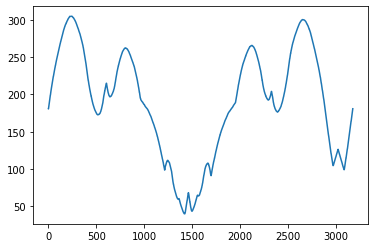

In [9]:
# To confirm that this is a continuous line that the vector gave us
plt.plot(contours[0, :, 0])
plt.show()

Text(0.5, 1.0, 'Squirrel, separated into line segments for interpolation')

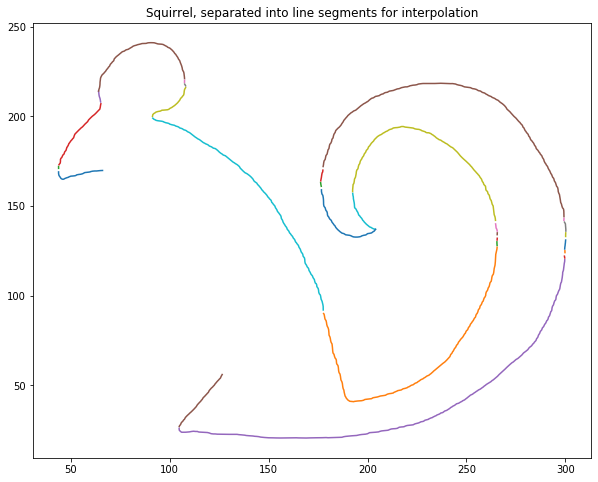

In [96]:
# Process so far: Use vectorization, grab roughly 50% of the line, since there's a start and end point
# Now that we have the continuous line traced, we'll run it through an algorithm to sectionize the line
line_contour = contours[0][row_start:row_end]

def extract_line_segments(line):
    """
    Extracts the line segments for vectorized contour lines such that there 
    are no overlapping Xs. Each of these line segments will be used for
    interpolating a spline. 
    
    Works by detecting the direction of the X, and every time it changes,
    it takes all data points starting at the last segment up until the current index
    to create a new segment, and then starts a new segment pair. 
    A positive direction is marked as True, whereas a decreasing X 
    is indicated as False.
    """
    all_segments = []

    for index, coordinate in enumerate(line):
        x, y = coordinate
        if index == 0:
            """
            Stick the initial two points into the segment array
            and get the first "prev_direction" (which will be the same 
            as the next on the initial run) to start the process.
            """
            segment_start = 0
            prev_direction = (x - line[1][0]) < 0
            previous_x = x
            continue
        direction = (x - previous_x) > 0

        if direction != prev_direction:
            all_segments.append(line[segment_start:index])
            segment_start = index
        previous_x = x
        prev_direction = direction
    return np.array(all_segments)

line_segments = extract_line_segments(line_contour)

plt.figure(figsize=(10, 8))
for line_segment in line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

plt.title("Squirrel, separated into line segments for interpolation")

We now reduce the number of line segments for this drawing from 36 to 19 segments total


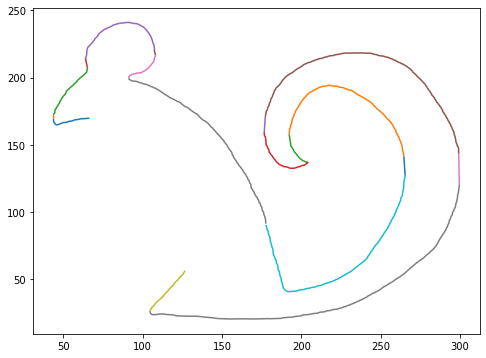

In [352]:
def handle_micro_segments(line_segments, threshold):
    """
    Detects a series of adjacent micro-segments and connects
    them into one larger segment for spline interpolation.
    
    Threshold indicates the number of points that a segment
    must fall under for it to be deemed "too small."
    """
    result = []
    aggregate_segment_indices = []
    aggregation_mode = False
    for index, segment in enumerate(line_segments):
        size = segment.shape[0]
        if size < threshold:
            if not aggregation_mode:
                aggregation_mode = True
                # Grab the first item of the small segment
                first_small_point = segment[0]
            else:
                # Keep grabbing segments
                continue
        else:
            # This means that we need to start small_segment 
            # over again because we saw a huge chunk
            # So, reset aggregation mode
            if aggregation_mode:
                # Save a bookmark to where the "aggregate" indices are
                aggregate_segment_indices.append(len(result))
                last_small_point = line_segments[index - 1][-1]
                # First small and last small should be points
                segment_of_small_points = np.array([first_small_point, last_small_point])
                result.append(segment_of_small_points)

            aggregation_mode = False
            result.append(segment)
    return (np.array(result), aggregate_segment_indices)
                

reduced_line_segments, aggregate_indices = handle_micro_segments(line_segments, 10)

# TODO: remove tiny segments, and maybe add a third point to any particularly vertical lines
# We can now also process the direction that the lines are going in, figure out the direction of the tiny segments
# And then append them to either end if possible

plt.figure(figsize=(8, 6))
for line_segment in reduced_line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

print(f"We now reduce the number of line segments for this drawing from {len(line_segments)} to {len(reduced_line_segments)} segments total")

Further reduced the number of line segments from 19 to 14


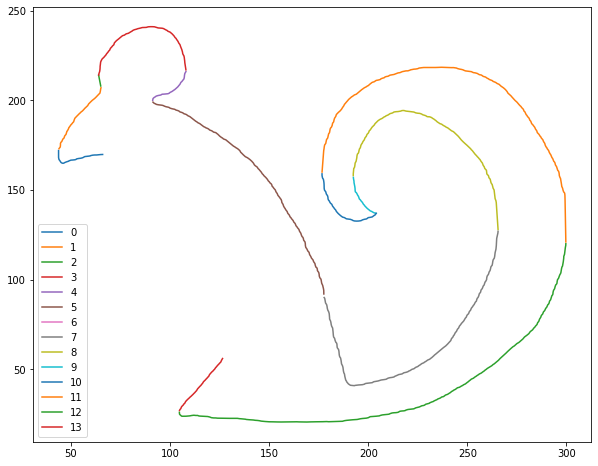

In [353]:

def attach_micro_segments_to_larger(line_segments, aggregate_segment_indices):
    """
    After running our line segments through extract_line_segments,
    our segments are guaranteed to go in one direction.
    
    We can take advantage of this property, to detect the direction
    of the mini line segments, and attach them to a neighboring larger one,
    such that we get even fewer "chunks."
    """
    result = []
    skip_next_iteration = False
    for index, line_segment in enumerate(line_segments):
        if index in aggregate_segment_indices:
            point_1, point_2 = line_segments[index]
            # Detect direction:
            direction = (point_2[0] - point_1[0]) > 0
            # Now, look at the direction of neighboring segments:
            
            # TODO: MAKE SURE THERE ARE NO LINE SEGMENTS EITHER END
            neighbor_1 = line_segments[index - 1]
            neighbor_2 = line_segments[index + 1]

            direction_neighbor_1 = (neighbor_1[1][0] - neighbor_1[0][0]) > 0
            direction_neighbor_2 = (neighbor_2[1][0] - neighbor_2[0][0]) > 0

            # Must always append the second point to the end of the first neighbor
            if direction == direction_neighbor_1:
                new_result = np.concatenate([result[-1], np.array([point_2])], axis=0)
                result[-1] = new_result

            # And the first point for the second neighbor on the right
            elif direction == direction_neighbor_2:
                new_segment = np.concatenate([np.array([point_1]), neighbor_2], axis=0)
                result.append(new_segment)
                skip_next_iteration = True
            else:
                result.append(line_segment)
        else:
            if skip_next_iteration:
                skip_next_iteration = False
            else:
                # If the segment is going in a different direction than either
                # neighbor, append it by itself.
                result.append(line_segment)
    return np.array(result)

final_segments = attach_micro_segments_to_larger(reduced_line_segments, aggregate_indices)

plt.figure(figsize=(10, 8))
for index, line_segment in enumerate(final_segments):
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys, label=index)
plt.legend()
    
print(f"Further reduced the number of line segments from {len(reduced_line_segments)} to {len(final_segments)}")

In [207]:
# https://stackoverflow.com/questions/4983258/python-how-to-check-list-monotonicity/4983359
def strictly_increasing(L):
    return all(x<y for x, y in zip(L, L[1:]))

def strictly_decreasing(L):
    return all(x>y for x, y in zip(L, L[1:]))

def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_increasing(L) or non_decreasing(L)

for final_segment in final_segments:
#     print(final_segment.shape)
#     print(monotonic(final_segment[:, 0]))
    
    print(final_segment)

[[ 66.         169.8039935 ]
 [ 65.         169.75384564]
 [ 64.         169.64465814]
 [ 63.         169.52529431]
 [ 62.         169.51793663]
 [ 61.         169.42208184]
 [ 60.         169.18078364]
 [ 59.68927813 169.        ]
 [ 59.         168.88068051]
 [ 58.         168.75515792]
 [ 57.         168.62610464]
 [ 56.         168.0166939 ]
 [ 55.98335625 168.        ]
 [ 55.         167.70786192]
 [ 54.         167.58004567]
 [ 53.         167.37903759]
 [ 52.48866615 167.        ]
 [ 52.         166.8502523 ]
 [ 51.         166.72603755]
 [ 50.         166.64048323]
 [ 49.         166.22134577]
 [ 48.70558846 166.        ]
 [ 48.         165.77785197]
 [ 47.         165.35582917]
 [ 46.43868542 165.        ]
 [ 46.         164.88320565]
 [ 45.5422413  165.        ]
 [ 45.         165.35059921]
 [ 44.63124788 166.        ]
 [ 44.         166.98504055]
 [ 43.99301686 167.        ]
 [ 43.78616436 168.        ]
 [ 43.77048571 169.        ]
 [ 43.77338474 172.        ]]
[[ 43.9725168

In [13]:
# Arg, I screwed up here somewhere. #TODO: MUST FIX
final_segments[0]

array([[ 66.        , 169.8039935 ],
       [ 65.        , 169.75384564],
       [ 64.        , 169.64465814],
       [ 63.        , 169.52529431],
       [ 62.        , 169.51793663],
       [ 61.        , 169.42208184],
       [ 60.        , 169.18078364],
       [ 59.68927813, 169.        ],
       [ 59.        , 168.88068051],
       [ 58.        , 168.75515792],
       [ 57.        , 168.62610464],
       [ 56.        , 168.0166939 ],
       [ 55.98335625, 168.        ],
       [ 55.        , 167.70786192],
       [ 54.        , 167.58004567],
       [ 53.        , 167.37903759],
       [ 52.48866615, 167.        ],
       [ 52.        , 166.8502523 ],
       [ 51.        , 166.72603755],
       [ 50.        , 166.64048323],
       [ 49.        , 166.22134577],
       [ 48.70558846, 166.        ],
       [ 48.        , 165.77785197],
       [ 47.        , 165.35582917],
       [ 46.43868542, 165.        ],
       [ 46.        , 164.88320565],
       [ 45.5422413 , 165.        ],
 

Line segments and local extrema


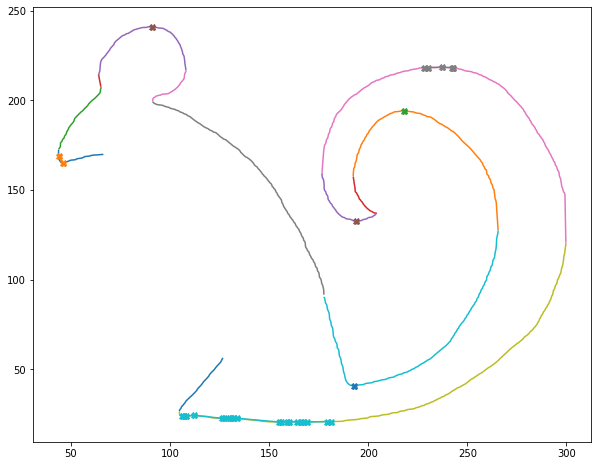

In [14]:
from scipy.signal import argrelextrema

def find_extrema(line_segments):
    """
    Find the indices of all local minima and maxima of a series of points,
    which we'll use as the starting point points for the interpolation
    
    Returns a tuple of the line segment itself, alongside the indices of where
    the extrema lie.
    """
    results = []
    for line_segment in line_segments:
        local_maxima = argrelextrema(line_segment, np.greater)[0]
        local_minima = argrelextrema(line_segment, np.less)[0]
        extrema = np.concatenate([local_maxima, local_minima])
        extrema.sort()
        results.append((line_segment, extrema))
    # We can further smooth out the local maxima and minima by looking through the array--if there are too many
    # indices "clustered together, figure out where that is happening and pick the result"
    return np.array(results)

# segment, extrema = find_extrema(final_segments[7])
# plt.plot(segment[:, 0], segment[:, 1])
# extrema_points = segment[extrema]
# plt.plot(extrema_points[:, 0], extrema_points[:, 1], marker="X")


plt.figure(figsize=(10, 8))
segments_with_extrema = find_extrema(final_segments)
for segment, extrema_indices in segments_with_extrema:
    xs = segment[:, 0]
    ys = segment[:, 1]
    plt.plot(xs, ys)
    if len(extrema_indices) > 0:
        extrema_xs = segment[extrema_indices][:, 0]
        extrema_ys = segment[extrema_indices][:, 1]
        plt.plot(extrema_xs, extrema_ys, marker="X")

print("Line segments and local extrema")

But, there are too many extrema clustered. We should pick out the clusters and the code to extract just a select group of extrema. 

Below, I've altered the function to reduce the number of selected extrema points!

dict_values([array([46.        , 43.77048571])])
dict_values([array([228., 230., 237., 242., 243.])])
dict_values([array([181., 179., 169., 167., 166., 164., 160., 159., 156., 155.]), array([134., 132., 131., 130., 127., 126.]), array([112., 108., 107., 106.])])
Line segments and local extrema


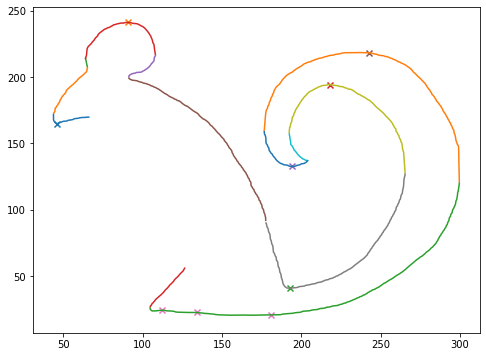

In [15]:
from scipy.signal import argrelextrema

"""
These next three functions are from stack overflow. Citation:
https://stackoverflow.com/questions/15800895/finding-clusters-of-numbers-in-a-list
"""
def cut_indices(numbers, tolerance):
    # this function iterate over the indices that need to be 'cut'
    for i in range(len(numbers)-1):
        if math.fabs(numbers[i+1] - numbers[i]) > tolerance:
            yield i+1

def splitter(numbers, tolerance):
    # this function split the original list into sublists.
    px = 0
    for x in cut_indices(numbers, tolerance):
        yield numbers[px:x]
        px = x
    yield numbers[px:]

def cluster(numbers, tolerance):
    # using the above result, to form a dict object.
    cluster_ids = range(1,len(numbers))
    return dict(zip(cluster_ids, splitter(numbers, tolerance)))

"""
\End chunk of Stack Overflow code.
"""

def find_extrema(line_segments, tolerance=10):
    """
    Find the indices of all local minima and maxima of a series of points,
    which we'll use as the starting points for the interpolation.
    
    Sometimes there will be multiple local minima and maxima clustered together
    due to the stochastic nature of a pencil stroke. The tolerance parameter checks 
    for any points that are within a certain distance of one another in terms of indices, 
    and returns the max of the sets.
    
    Returns a tuple of the line segment itself, alongside the indices of where
    the extrema lie.
    """
    results = []
    for line_segment in line_segments:
        local_maxima = argrelextrema(line_segment, np.greater)[0]
        local_minima = argrelextrema(line_segment, np.less)[0]
        extrema_indices = np.concatenate([local_maxima, local_minima])
        extrema_indices.sort()
        
        if len(extrema_indices) > 1:
            # We can further smooth out the local maxima and minima by looking through the array--if there are too many
            # indices "clustered together, figure out where that is happening and pick the result"
            # If there are a lot of local minima and maxima clustered together 
            x_values = line_segment[extrema_indices][:, 0]
            # OOPS: These are not the indices of the original line segments
            clusters = cluster(x_values, tolerance)

            extrema_indices = []
            print(clusters.values())
            for c in clusters.values():
                # For each cluster, just pick one point
                # I just picked the max for now. 
                # TODO: REVIIST THIS, MAYBE SEPARATE IT OUT FOR MAXES AND MINS?
                extrema_indices.append(np.array(c).max())
            extrema_indices = [np.where(line_segment[:, 0] == e)[0][0] for e in extrema_indices]        
        results.append((line_segment, extrema_indices))

    return np.array(results)

plt.figure(figsize=(8, 6))

segments_with_extrema = find_extrema(final_segments, tolerance=10)
for segment, extrema_indices in segments_with_extrema:
    xs = segment[:, 0]
    ys = segment[:, 1]
    plt.plot(xs, ys)
    if len(extrema_indices) > 0:
        extrema_xs = segment[extrema_indices][:, 0]
        extrema_ys = segment[extrema_indices][:, 1]
        plt.scatter(extrema_xs, extrema_ys, marker="x")

print("Line segments and local extrema")

Now, with a reduced number of extrema, we can use these as points to start interpolating.

(Also, not sure if I just wasted a ton of time finding local minima and maxima. I think I did.)

Aside from documentation of the tools used (see imports above), here are some resources
I used as reference:

- http://freeconnection.blogspot.com/2013/07/vectorize-image-with-python-scikit-image.html

#### ---------------------------------- WARNING AND APOLOGIES - The code gets uglier as the night goes on ------------------------

## Using Parametric Curves

Iteration: 10
X Parameteric Splines, we have 11 coefficients
Y Parameteric Splines, we have 11 coefficients
With Error of 632433.7865193123
Total number of T-Points Interpolated so far: 12


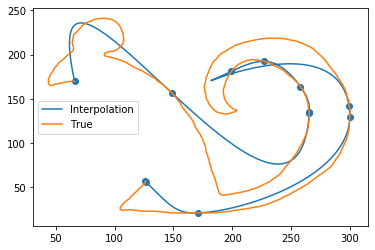



Iteration: 20
X Parameteric Splines, we have 21 coefficients
Y Parameteric Splines, we have 21 coefficients
With Error of 191052.88914314794
Total number of T-Points Interpolated so far: 22


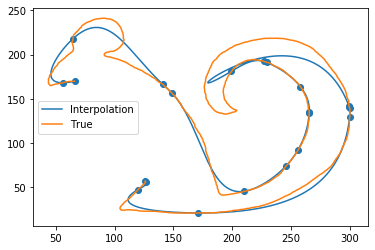



Iteration: 30
X Parameteric Splines, we have 31 coefficients
Y Parameteric Splines, we have 31 coefficients
With Error of 157984.61799518453
Total number of T-Points Interpolated so far: 32


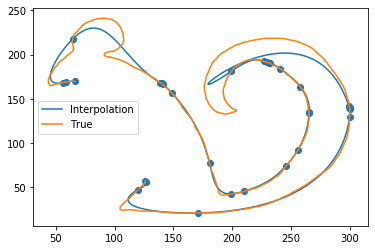



Iteration: 40
X Parameteric Splines, we have 41 coefficients
Y Parameteric Splines, we have 41 coefficients
With Error of 155655.45733946044
Total number of T-Points Interpolated so far: 42


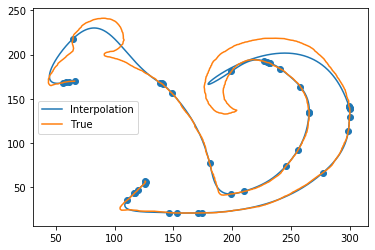



Iteration: 50
X Parameteric Splines, we have 51 coefficients
Y Parameteric Splines, we have 51 coefficients
With Error of 155303.00060868758
Total number of T-Points Interpolated so far: 52


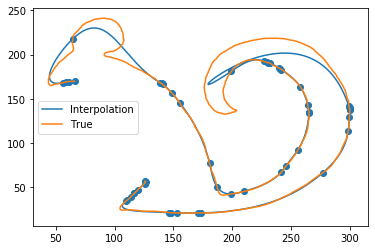



Iteration: 60
X Parameteric Splines, we have 61 coefficients
Y Parameteric Splines, we have 61 coefficients
With Error of 155123.13522259204
Total number of T-Points Interpolated so far: 62


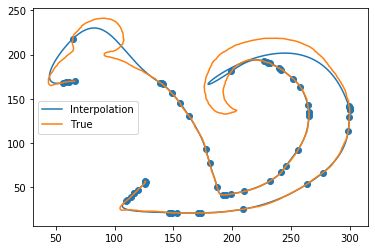



Iteration: 70
X Parameteric Splines, we have 71 coefficients
Y Parameteric Splines, we have 71 coefficients
With Error of 155019.37398002512
Total number of T-Points Interpolated so far: 72


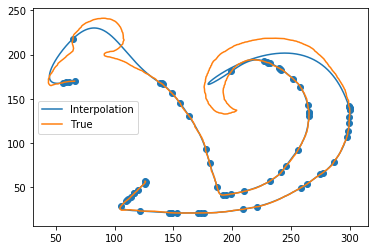

KeyboardInterrupt: 

In [106]:
from scipy.interpolate import lagrange, CubicSpline

def evaluate_error(line_vector, spline_xs, spline_ys):
    # TODO: double check that this is in fact right
    xs = line_vector[:, 0]
    ys = line_vector[:, 1]
    
    squared_diff_xy = np.square(xs - spline_xs) + np.square(ys - spline_ys)
    total_error = squared_diff_xy.sum()
    return total_error

def find_cubic_splines(line_vector, tolerance):
    """
    Iteratively calculates the two cubic splines
    that describe the X and Y coordinates to parametrically
    plot a vector––an approach outlined by Chris.
    """
    tolerance = 100
    N = len(line_vector) - 1
    L = [0, N]
    points_at_indices = line_vector[L]
    all_points = np.arange(0, N, 1)

    # Initiate E to allow the for loop to happen
    E = 10 ** 8
    # The total number of indices in the original vector
    Ts = len(line_vector)
    
    iteration = 0
    while E > tolerance:
        # Initiate the error with a random number
        error_best = 10 ** 100
        for i in range(1, N):
            # Grab three points for the cubic spline: 
            # the first point, second point, third point
            if i in L:
                continue
            L_new = L + [i]
            L_new.sort()
            points_at_indices = line_vector[L_new]
            
            # Draw a numpy array from a binomial distribution same number of points
            # binomial with n = 1, so every index is 
            
            xs = points_at_indices[:, 0]
            ys = points_at_indices[:, 1]
            
            cubic_spline_x = CubicSpline(L_new, xs)
            cubic_spline_y = CubicSpline(L_new, ys)
            
            spline_ts = np.arange(0, len(line_vector), 1)                                                                                                                                     
            spline_xs = cubic_spline_x(spline_ts)
            spline_ys = cubic_spline_y(spline_ts)
            
            error_new = evaluate_error(line_vector, spline_xs, spline_ys)
            
            # If the new error is better than the old error, then 
            # start tracking this instead
            if error_new < error_best:
                best_index = i
                error_best = error_new

        # After a full iteration, append the point into the 
        # mega-array with all Spline points
        # And keep iterating until it's successful
        E = error_best
        L.append(best_index)
        L.sort()
        iteration += 1
        # Only print every 10th iteration
        if iteration % 10 == 0:
            points_at_indices = line_vector[L]
            xs = points_at_indices[:, 0]
            ys = points_at_indices[:, 1]
        
            cubic_spline_x = CubicSpline(L, xs)
            cubic_spline_y = CubicSpline(L, ys)
        
            spline_xs = cubic_spline_x(all_points)
            spline_ys = cubic_spline_y(all_points)
            x_coefficients = cubic_spline_x.c
            y_coefficients = cubic_spline_y.c
            
            print(f"Iteration: {iteration}")
            # TODO: USE THIS STACK OVERFLOW POST TO INTERPET THE COEFFICIENTS:
            # https://stackoverflow.com/questions/43458414/python-scipy-how-to-get-cubic-spline-equations-from-cubicspline
            print(f"X Parameteric Splines, we have {len(x_coefficients[0])} coefficients")
            print(f"Y Parameteric Splines, we have {len(y_coefficients[0])} coefficients")
            print(f"With Error of {E}")
            print("Total number of T-Points Interpolated so far:", len(L))
            plt.plot(spline_xs, spline_ys, label="Interpolation")
            plt.plot(line_vector[:, 0], line_vector[:, 1], label="True")
            plt.scatter(xs, ys)
            plt.legend()
            plt.show()
            print("\n")
    
    # Now, once again, grab all points at the specified indices
    L.sort()
    points_at_indices = line_vector[L]
    xs = points_at_indices[:, 0]
    ys = points_at_indices[:, 1]
    
    # And stick them into the cubic spline function to calculate the 
    # supposed "best" line of fit
    cubic_spline_x = CubicSpline(points_at_indices, xs)
    cubic_spline_y = CubicSpline(points_at_indices, ys)
    return (cubic_spline_x, cubic_spline_y)
    
points = np.linspace(0, len(line_contour), 100)
cubic_spline_x, cubic_spline_y = find_cubic_splines(line_contour, 10)


An error of ~1000 or so is considered good when using the double contour line in terms of what looks good;
Interestingly, this doesn't work so well when we pass the single-line segment in. With a single line segment, the error differnece between iterations starts converging to 0 and not looking like the squirrel, so I suspect that we are getting stuck in local minimum. I played around with adding some stochasticity (randomly dropping some indices), but it didn't work so well.

## FITTING WITH POLYNOMIALS

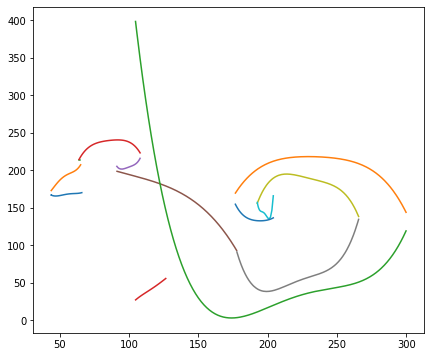

In [216]:
from numpy.polynomial.polynomial import Polynomial

# The below "find_nearest" function is from: 
# Stack Overflow: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def get_chebyshev_points(points):
    """
    From my first homework.
    """
    chebyshev_points = []
    n = len(points)
    for j in points:
        chebyshev_points.append(math.cos(((2 * j - 1) / (2 * n))* math.pi))
    return np.array(chebyshev_points)


def interpolate_segment(segment, points_to_interpolate):
    """
    Interpolates the segment using Chebyshev points.
    """
    segments_x = segment[:, 0]
    segments_y = segment[:, 1]

    # Get the beginning and end intervals
    start = int(segments_x[0])
    end = int(segments_x[-1])
    if start - end > 0:
        interval = -1
    else:
        interval = 1
    
    points = np.arange(start, end, interval)
    intervals = np.max([math.ceil(len(segments_x) / points_to_interpolate), 1])
    points_to_interp = segments_x[1::intervals]
    interpolation_indices = [np.where(segments_x == p)[0][0] for p in points_to_interp]
    
    lagrange_interpolation = lagrange(segments_x[interpolation_indices], segments_y[interpolation_indices])
    approx_ys = lagrange_interpolation(segments_x)
    return segments_x, approx_ys
    
plt.figure(figsize=(7, 6))
for i, segment in enumerate(final_segments):
    xs, ys = interpolate_segment(segment, 5)
    plt.plot(xs, ys)
    

As we know, Lagrange polynomial is too unstable, and it looks increasingly worse with the more points we pass it; and as the documentaiton says, we should limit to 20 points. Based on this, the Lagrange probably isn't too promising. I tried finding the Chebyshev points, but got some weird results (possibly just bugs in my code).

1500000 100000
100000 33.87415957646257
33.87415957646257 24.355602848964235
24.355602848964235 18.0635065067706
7
1500000 100000
100000 10.020403885887008
10.020403885887008 8.879668792224766
8.879668792224766 8.406283501182601
8.406283501182601 8.323107698278474
8.323107698278474 8.22594848229143
8.22594848229143 8.124090957436286
8.124090957436286 8.053100431899441
1500000 100000
100000 4.281305904815475e-26
5
1500000 100000
100000 246.58380220044143
246.58380220044143 69.26816950001871
69.26816950001871 61.77072344391831
61.77072344391831 60.150012732538194
60.150012732538194 59.54367189102653
59.54367189102653 59.0910371117893
59.0910371117893 57.148106452204765
1500000 100000
100000 4.823692880436769
4.823692880436769 4.813023962593286
6
1500000 100000
100000 101.56866574360112
101.56866574360112 90.88100581137984
90.88100581137984 85.98563755580552
7
1500000 100000
100000 0.0
5
1500000 100000
100000 6298.499496050698
6298.499496050698 1134.2658184329136
6
1500000 100000
100000 1

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


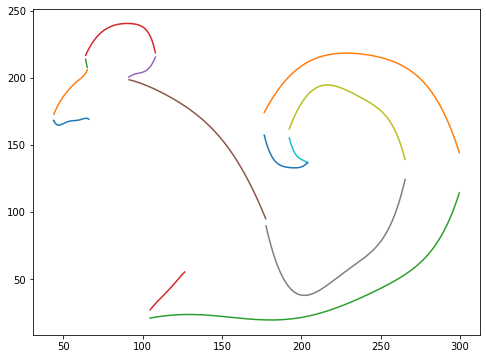

In [284]:
def apply_polynomial(coeffs, x):
    resulting_y = 0
    # Grab all but the last weight
    for index, c in enumerate(coeffs):
        order = len(coeffs) - index - 1
        resulting_y += (c * (x ** order))
    return resulting_y
        

def fit_with_least_squares(segment, order, max_order=10):
    """
    Fits using least squares; iteratively increases the order
    """
    # TODO: CLEAN THIS UP
    
    previous_error = 1500000
    error = 100000
    # As long as the error decreases -- because we can overfit to the point of it actually 
    # increasing error
    ## TO NOTE: AT A CERTAIN POINT IT OVERFITS AND ERRROR INCREASES
    while previous_error > error:
        print(previous_error, error)
        previous_error = error
        matrix_shape = (len(segment), order + 1)
        vandermonde_matrix = np.zeros(matrix_shape)
        
        xs = segment[:, 0]
        ys = segment[:, 1]

        a = xs[0]
        b = xs[-1]
        c = ys[0]
        d = ys[-1]
        
        for n in range(order, -1, -1):
            xs_power = xs** n
            column_position = order - n
            vandermonde_matrix[:, column_position] = xs_power
        weights = np.linalg.lstsq(vandermonde_matrix, ys)[0]
        # Now, loop through each of the xs and calculate
        # Using the polynomial returned
        estimated_ys = []
        for x in xs:
            y = apply_polynomial(weights, x)
            estimated_ys.append(y)
        diff = estimated_ys - ys
        
        error = ((np.linalg.norm(diff)** 2))
        order += 1
        if order > max_order:
            return xs, estimated_ys
    print(order)
    return xs, estimated_ys

plt.figure(figsize=(8,6))
for i, segment in enumerate(final_segments):
    xs, ys = fit_with_least_squares(segment, 3)
    plt.plot(xs, ys)
    
# TODO: MAKE SOME PLOTS SHOWING THE ERROR CONVERGING OVER TIME FOR EACH SEGMENT



# WELL, I GOT THE LINES TO CONNECT, BUT THIS CERTAINLY DOES NOT INTERPOLATE WELL

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


7
7
5
7
6
7
4
7
7
6
7
7
7
7


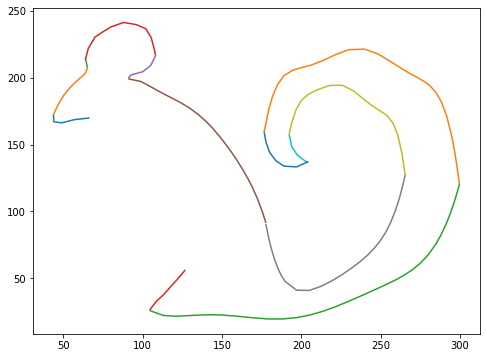

In [346]:
# Now, we'll attempt to revise the "fit with least squares" method to fix the endpoints.
# However, as you run this, you'll notice that we encounter issues of numerical stability.
# it nminimizes error by increasing the polynomial quite a bit, so we should write about it:
# https://en.wikipedia.org/wiki/Numerical_stability

# Also, to make this work well, had to sample the number of items at intervals.

def apply_polynomial(coeffs, x, a):
    resulting_y = 0
    # Grab all but the last weight
    for index, c in enumerate(coeffs):
        order = len(coeffs) - index - 1
        resulting_y += (c * ((x  - a )** order))
    return resulting_y
        

def fit_with_least_squares(segment, order, max_order=5):
    """
    Fits using least squares; iteratively increases 
    the order until the error is sufficiently minimized.
    """
    previous_error = 1500000
    error = 100000

    while previous_error > error:
#         print(previous_error, error)
        previous_error = error
        matrix_shape = (len(segment), order + 1)
        vandermonde_matrix = np.zeros(matrix_shape)
    
        xs = segment[:, 0]
        ys = segment[:, 1]

        a = xs[0]
        b = xs[-1]
        c = ys[0]
        d = ys[-1]
        
        # Because we are adding the extra term, 
        # the lowest polynomial order is actually 5, 
        # if we start it at 3.
        
        for n in range(order, -1, -1):
            # At a high level, what is happening is that we are adjusting the 
            # data in the Vandermonde Matrix to fix the points at zero.
            # But in order to do that, we need to adjust the rest of the data 
            # to remain Consistent.
            
            # Prior to this, what is happening is that we created a poorly 
            # conditioned Matrix because the Y values did not correspond to the Xs.
            xs_power = ((xs - a) * (xs - b)) * ((xs - a) ** n)
            column_position = order - n
            vandermonde_matrix[:, column_position] = xs_power
        matrix_ys = [y - c - ((d - c) * ((x - a) / (b - a))) for x, y in zip(xs, ys)]
        weights = np.linalg.lstsq(
            vandermonde_matrix, 
            np.array(matrix_ys)
        )[0]
        # Now, loop through each of the xs and calculate
        # Using the polynomial returned
        
        # Probably neeed to write about numerical instability;
        estimated_ys = []
        for x in xs:
            qx = apply_polynomial(weights, x, a)
            y = c + ((d - c) * ((x - a) / (b - a))) + ((x - a) * (x - b) * qx)
            estimated_ys.append(y)
        diff = estimated_ys - ys
        
        error = ((np.linalg.norm(diff)** 2))
        order += 1
        if order > max_order:
            print(order + 2)
            return xs, estimated_ys
    print(order + 2)
    return xs, estimated_ys

plt.figure(figsize=(8,6))
for i, segment in enumerate(final_segments):
    sampled_segment = np.concatenate([segment[0:-1:10], np.array([segment[-1]])])
    xs, ys = fit_with_least_squares(sampled_segment, 1, 4)
    plt.plot(xs, ys)


Iteration: 1
X Parameteric Splines, we have 3 coefficients
Y Parameteric Splines, we have 3 coefficients
With Error of 747577.8146346109
Total number of T-Points Interpolated so far: 4


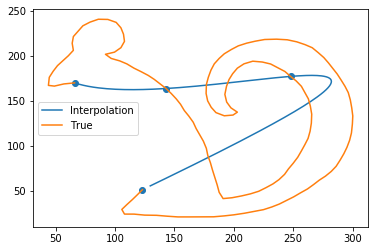

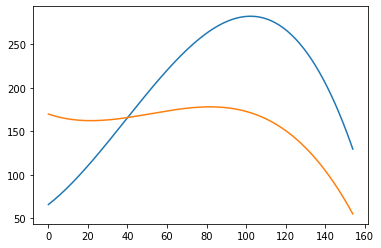

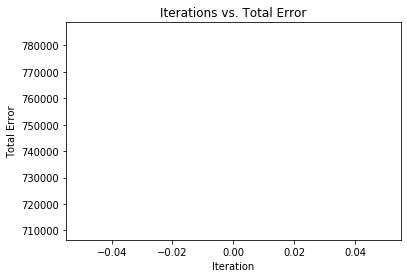



Iteration: 2
X Parameteric Splines, we have 5 coefficients
Y Parameteric Splines, we have 5 coefficients
With Error of 270039.1593674312
Total number of T-Points Interpolated so far: 6


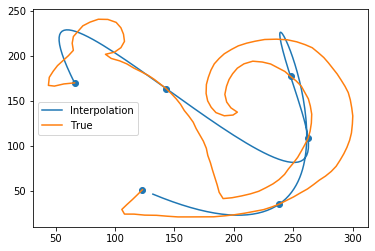

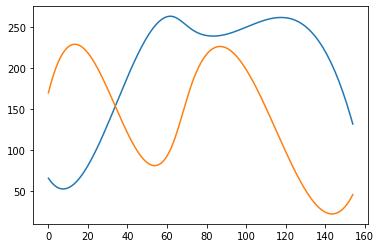

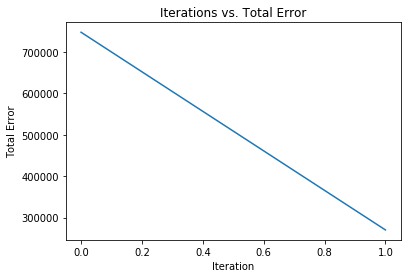



Iteration: 3
X Parameteric Splines, we have 7 coefficients
Y Parameteric Splines, we have 7 coefficients
With Error of 79108.53461810878
Total number of T-Points Interpolated so far: 8


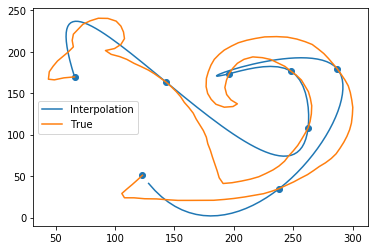

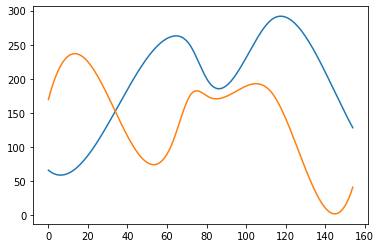

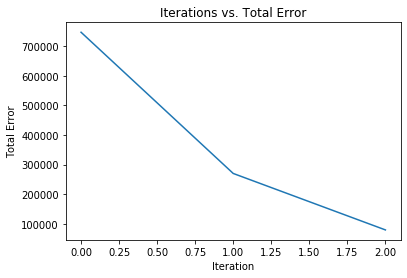



Iteration: 4
X Parameteric Splines, we have 9 coefficients
Y Parameteric Splines, we have 9 coefficients
With Error of 44410.971872395494
Total number of T-Points Interpolated so far: 10


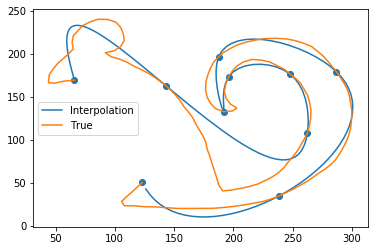

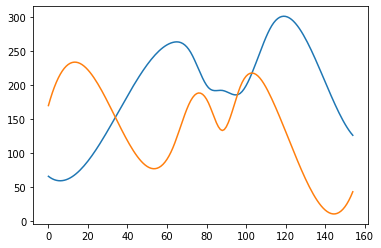

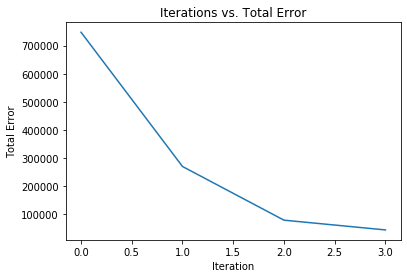



Iteration: 5
X Parameteric Splines, we have 11 coefficients
Y Parameteric Splines, we have 11 coefficients
With Error of 19856.36674700095
Total number of T-Points Interpolated so far: 12


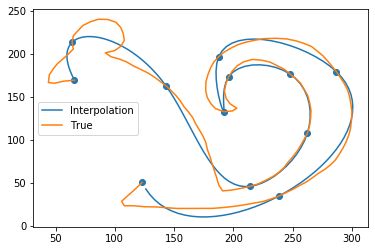

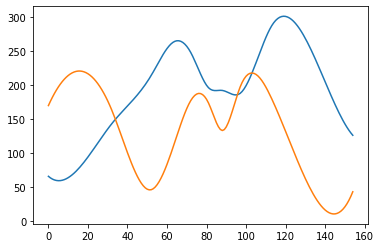

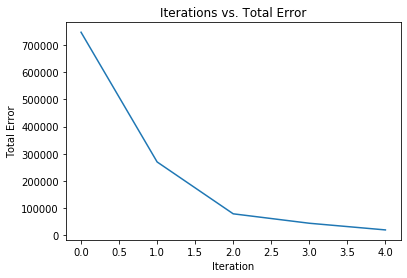



Iteration: 6
X Parameteric Splines, we have 13 coefficients
Y Parameteric Splines, we have 13 coefficients
With Error of 11255.4066954831
Total number of T-Points Interpolated so far: 14


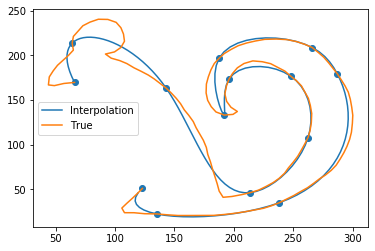

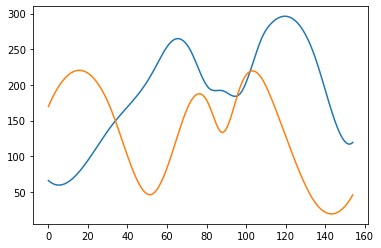

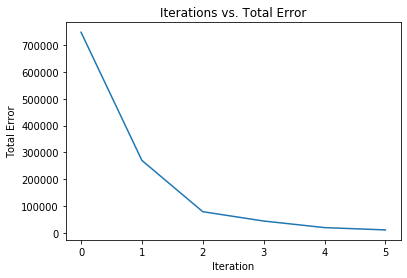



Iteration: 7
X Parameteric Splines, we have 15 coefficients
Y Parameteric Splines, we have 15 coefficients
With Error of 4929.880964667922
Total number of T-Points Interpolated so far: 16


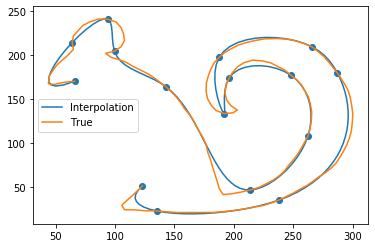

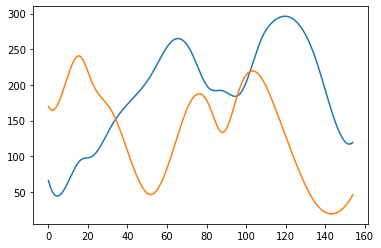

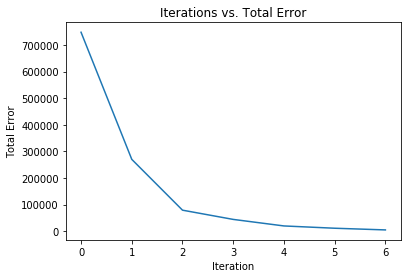



Iteration: 8
X Parameteric Splines, we have 17 coefficients
Y Parameteric Splines, we have 17 coefficients
With Error of 3400.1341478683
Total number of T-Points Interpolated so far: 18


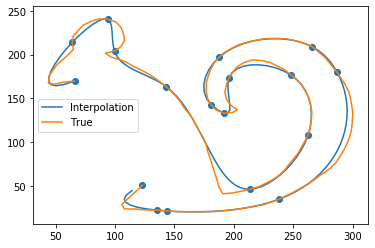

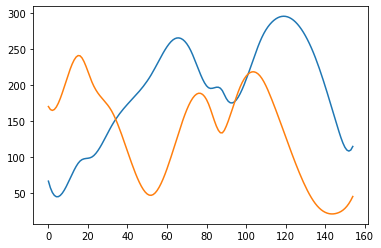

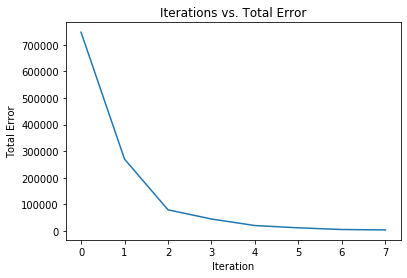



Iteration: 9
X Parameteric Splines, we have 19 coefficients
Y Parameteric Splines, we have 19 coefficients
With Error of 2535.6611328185604
Total number of T-Points Interpolated so far: 20


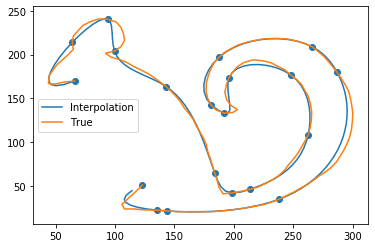

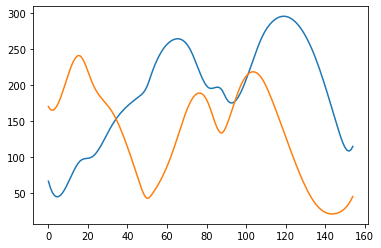

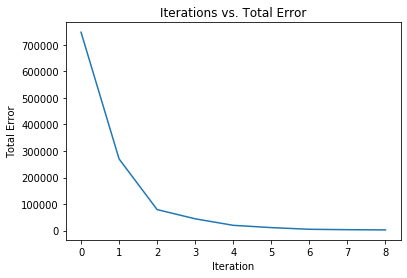



Iteration: 10
X Parameteric Splines, we have 21 coefficients
Y Parameteric Splines, we have 21 coefficients
With Error of 1713.851343607224
Total number of T-Points Interpolated so far: 22


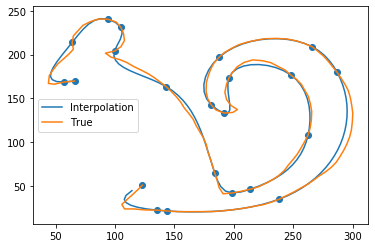

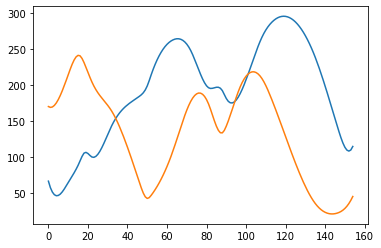

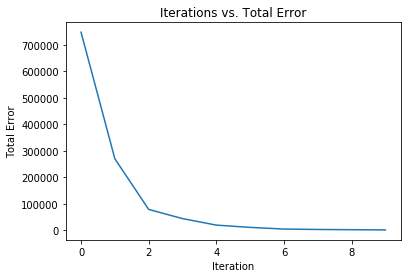



Iteration: 11
X Parameteric Splines, we have 23 coefficients
Y Parameteric Splines, we have 23 coefficients
With Error of 1114.3455997586807
Total number of T-Points Interpolated so far: 24


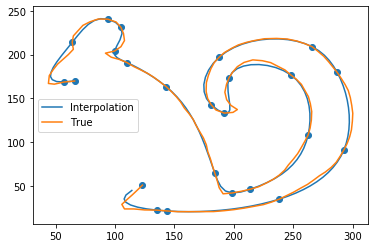

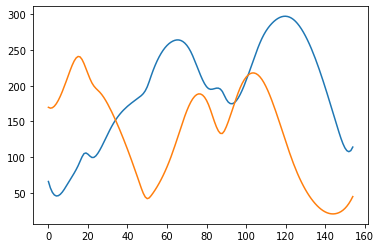

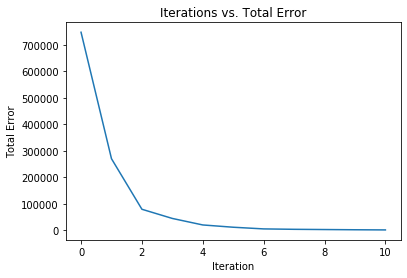



Iteration: 12
X Parameteric Splines, we have 25 coefficients
Y Parameteric Splines, we have 25 coefficients
With Error of 881.1021582572927
Total number of T-Points Interpolated so far: 26


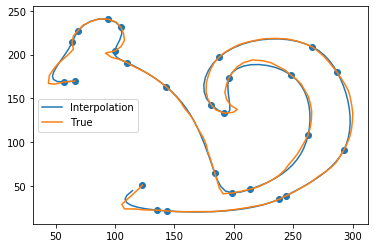

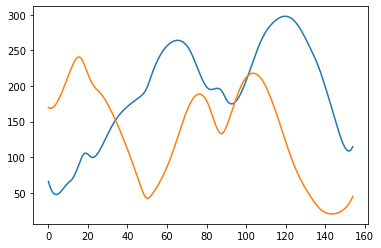

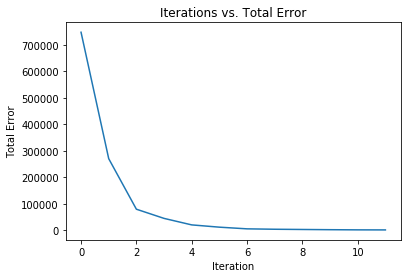



Iteration: 13
X Parameteric Splines, we have 27 coefficients
Y Parameteric Splines, we have 27 coefficients
With Error of 720.6178121737653
Total number of T-Points Interpolated so far: 28


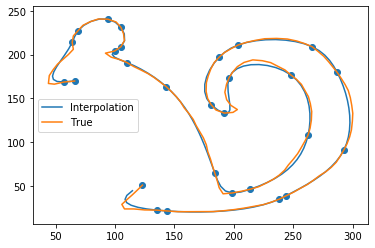

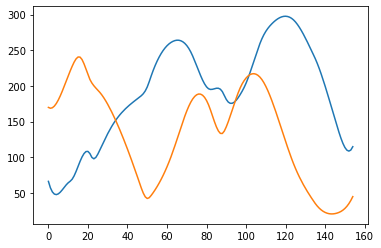

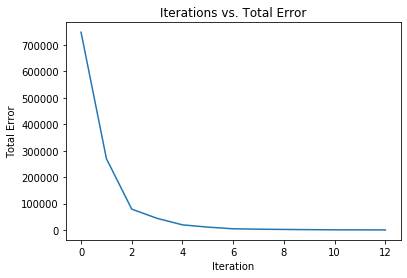



Iteration: 14
X Parameteric Splines, we have 29 coefficients
Y Parameteric Splines, we have 29 coefficients
With Error of 581.6862481970597
Total number of T-Points Interpolated so far: 30


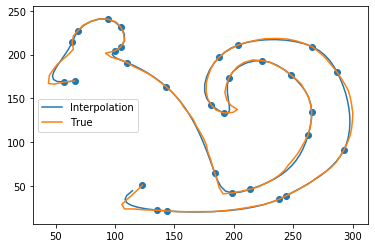

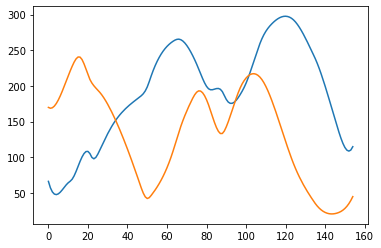

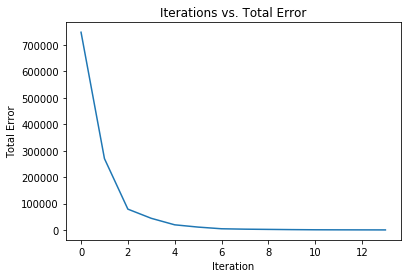



Iteration: 15
X Parameteric Splines, we have 31 coefficients
Y Parameteric Splines, we have 31 coefficients
With Error of 465.26542942414267
Total number of T-Points Interpolated so far: 32


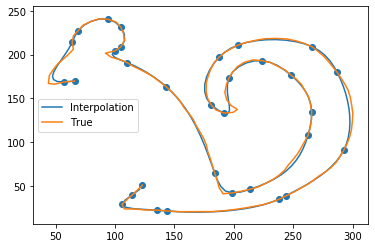

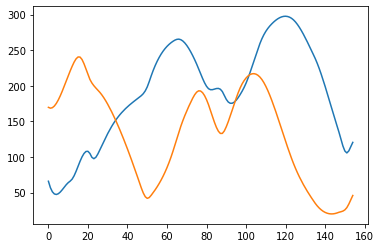

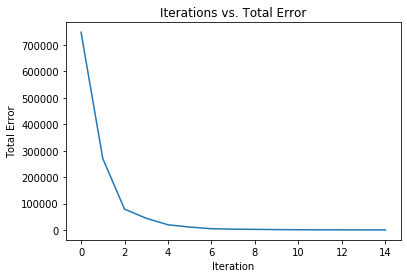



Iteration: 16
X Parameteric Splines, we have 33 coefficients
Y Parameteric Splines, we have 33 coefficients
With Error of 354.55720229752245
Total number of T-Points Interpolated so far: 34


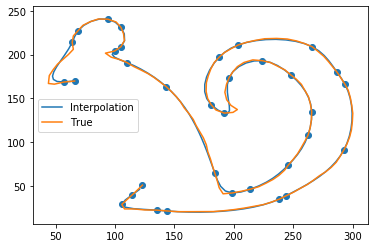

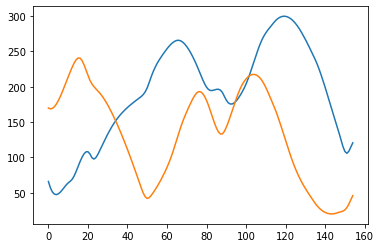

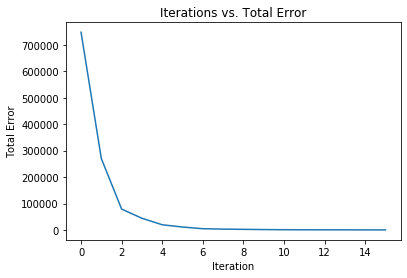



Iteration: 17
X Parameteric Splines, we have 35 coefficients
Y Parameteric Splines, we have 35 coefficients
With Error of 283.4695763440757
Total number of T-Points Interpolated so far: 36


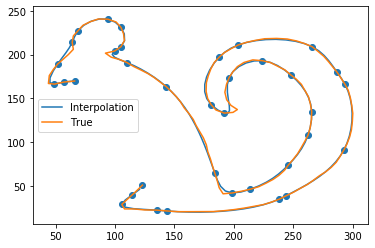

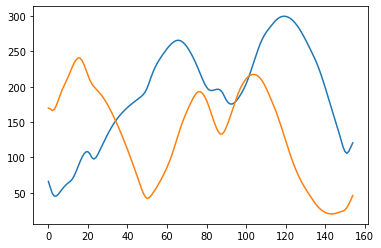

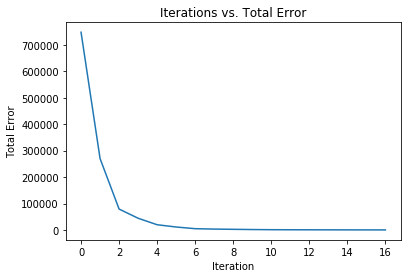



Iteration: 18
X Parameteric Splines, we have 37 coefficients
Y Parameteric Splines, we have 37 coefficients
With Error of 212.48923795217277
Total number of T-Points Interpolated so far: 38


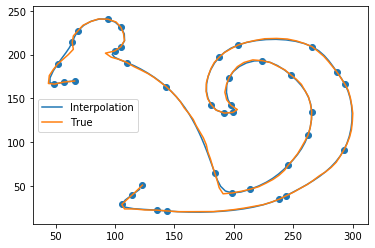

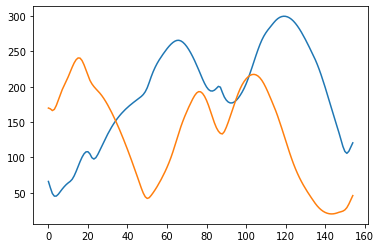

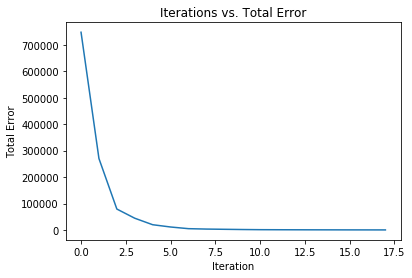

KeyboardInterrupt: 

In [231]:
# Create a function to test the spline interpolation on
def evaluate_error(line_vector, spline_xs, spline_ys):
    # TODO: double check that this is in fact right
    xs = line_vector[:, 0]
    ys = line_vector[:, 1]
    
    squared_diff_xy = np.square(xs - spline_xs) + np.square(ys - spline_ys)
    total_error = squared_diff_xy.sum()
    return total_error

def find_cubic_splines_two_points(line_vector, tolerance):
    tolerance = 10
    N = len(line_vector) - 1
    L = [0, N]
    points_at_indices = line_vector[L]
    all_points = np.arange(0, N, 1)

    # Initiate E to allow the for loop to happen
    E = 10 ** 8
    # The total number of indices in the original vector
    Ts = len(line_vector)
    
    running_error = []
    iteration = 0
    while E > tolerance:
        
        # Initialize the error with a random number
        error_best = 10 ** 100

        # Try all possible pairs of points (i,j)
        for i in range(1, N):
            if i in L:
                continue
                
            for j in range(1,N):
                
                if j==i or j in L:
                    continue
                    
                # TODO: The point at which X changes directions, 
                # anchor this item down as a control point. 
                # (copy and paste the code from my segmentation algorithm)
                # As long as the last point is not that far.

                # Try adding the pair to the control point list 
                L_new = L + [i,j]
                L_new.sort()
                points_at_indices = line_vector[L_new]
                
                xs = points_at_indices[:, 0]
                ys = points_at_indices[:, 1]
                
                cubic_spline_x = CubicSpline(L_new, xs)
                cubic_spline_y = CubicSpline(L_new, ys)
                
                spline_ts = np.arange(0, len(line_vector), 1)                                                                                                                                     
                spline_xs = cubic_spline_x(spline_ts)
                spline_ys = cubic_spline_y(spline_ts)
                
                error_new = evaluate_error(line_vector, spline_xs, spline_ys)
                
                # If the new error is better than the old error, then 
                # start tracking this instead
                if error_new < error_best:
                    best_index = [i,j]
                    error_best = error_new

        # After a full iteration, append the point into the 
        # mega-array with all Spline points
        # And keep iterating until it's successful
        E = error_best
        running_error.append(E)
        L = L + (best_index)
        L.sort()
        iteration += 1

        # Print every iteration 
        if iteration % 1 == 0:
            points_at_indices = line_vector[L]
            xs = points_at_indices[:, 0]
            ys = points_at_indices[:, 1]
        
            cubic_spline_x = CubicSpline(L, xs)
            cubic_spline_y = CubicSpline(L, ys)
        
            spline_xs = cubic_spline_x(all_points)
            spline_ys = cubic_spline_y(all_points)
            x_coefficients = cubic_spline_x.c
            y_coefficients = cubic_spline_y.c
            
            print(f"Iteration: {iteration}")
            print(f"X Parameteric Splines, we have {len(x_coefficients[0])} coefficients")
            print(f"Y Parameteric Splines, we have {len(y_coefficients[0])} coefficients")
            print(f"With Error of {E}")
            print("Total number of T-Points Interpolated so far:", len(L))
            plt.plot(spline_xs, spline_ys, label="Interpolation")
            plt.plot(line_vector[:, 0], line_vector[:, 1], label="True")
            plt.scatter(xs,ys)
            plt.legend()
            plt.show()
            
            
            plt.plot(all_points, spline_xs)
            plt.plot(all_points, spline_ys)
            plt.show()
            
            plt.plot(running_error)
            plt.title("Iterations vs. Total Error")
            plt.xlabel("Iteration")
            plt.ylabel("Total Error")
            plt.show()
            print("\n")
    
    # Now, once again, grab all points at the specified indices
    L.sort()
    points_at_indices = line_vector[L]
    xs = points_at_indices[:, 0]
    ys = points_at_indices[:, 1]
    
    # And stick them into the cubic spline function to calculate the 
    # supposed "best" line of fit
    cubic_spline_x = CubicSpline(L,xs)
    cubic_spline_y = CubicSpline(L,ys)
    return (cubic_spline_x, cubic_spline_y)

points = np.linspace(0, len(filtered_line_contour), 100)
cubic_spline_x, cubic_spline_y = find_cubic_splines_two_points(filtered_line_contour, 10)

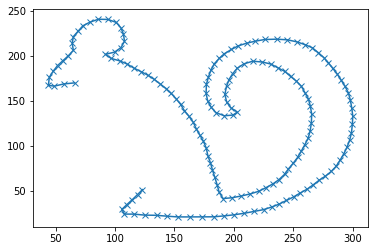

In [105]:
filtered_line_contour = line_contour[0:-1:10]
plt.plot(filtered_line_contour[:, 0], filtered_line_contour[:, 1], marker="x")

We can also write about the idea of runtime here; with the original set of vectors, it would be 1500 points; if we reduced it down to 150, the fit may be less accurate, but at least it runs faster.

In [ ]:
cubic_spline_x()

[-8.87885218e-01 -8.16969893e-01 -7.30835964e-01 -6.31087944e-01 -5.19583950e-01 -3.98401090e-01 -2.69796771e-01 -1.36166649e-01  3.06161700e-16  1.36166649e-01  2.69796771e-01  3.98401090e-01  5.19583950e-01  6.31087944e-01  7.30835964e-01  8.16969893e-01  8.87885218e-01  9.42260922e-01  9.79084088e-01  9.97668769e-01  9.97668769e-01  9.79084088e-01  9.42260922e-01]
[66.         65.10878566 64.02631453 62.772751   61.37144658 59.84850493 58.23229557 56.55292541 54.84167796 53.1304305  51.45106034 49.83485098 48.31190933 46.91060491 45.65704138 44.57457025 43.68335591 43.         43.         43.         43.         43.         43.        ]
[-0.70710678 -0.70710678]
[43. 43.]
[ 0.97714687  0.99745211  0.99745211  0.97714687  0.93694972  0.87767899  0.80054124  0.70710678  0.59927767  0.47924899  0.34946418  0.21256529  0.07133918 -0.07133918 -0.21256529 -0.34946418 -0.47924899 -0.59927767 -0.70710678 -0.80054124 -0.87767899 -0.93694972]
[65. 65. 65. 65. 65. 65. 65. 65. 65. 65. 65. 65. 6

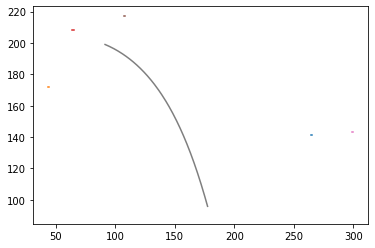

In [354]:
# The below "find_nearest" function is from:
# Stack Overflow: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# def scale_values (array, minimum, maximum):
#     ## It might be that scaling the range doesn't work because
#     array += -(np.min(array))
#     array /= np.max(array) / (maximum - minimum)
#     array += minimum
#     return array

# def scale_values(array, minimum, maximum):
#     min_array = array[0]
#     max_array = array[-1]
#     maximum - minimum
#     b =

def get_chebyshev_points(points):
    """
    From my first homework.
    """ 
    chebyshev_points = []
    n = len(points)
    for j in points:
        chebyshev_points.append(math.cos(((2 * j - 1) / (2 * n))* math.pi))
    return np.array(chebyshev_points)

def interpolate_segment(segment):
    # Grab the chebyshev, scale them up, and also include the first and last endpoints
    segments_x = segment[:, 0]
    segments_y = segment[:, 1]

    # Get the beginning and end intervals
    start = int(segments_x[0])
    end = int(segments_x[-1])
    if start - end > 0:
        interval = -1
    else:
        interval = 1
    if len(segments_x) > 2:
        points = np.arange(start, end, interval)
    else:
        points = np.array([start, end])
    cb_p = get_chebyshev_points(points)
    # This gets screwed up when X changes directions
    print(cb_p)
    cb_p_scaled = np.interp(cb_p, (cb_p[0], cb_p[-1]), (start, end))
    print(cb_p_scaled)
    
    # And then find the chebyshev points that are the nearest to the actual vector itself
    all_points = [find_nearest(segments_x, c) for c in cb_p_scaled]

    # Take the max of 1 in case we have fewer than 5 points
    intervals = np.max([math.ceil(len(all_points) / 5), 1])
    points_to_interp = all_points[1::intervals]
    interpolation_indices = [np.where(segments_x == p)[0][0] for p in points_to_interp]

    lagrange_interpolation = lagrange(segments_x[interpolation_indices], segments_y[interpolation_indices])
    approx_ys = lagrange_interpolation(segments_x)
    return segments_x, approx_ys

for i, segment in enumerate(reduced_line_segments):
    xs, ys = interpolate_segment(segment)
    plt.plot(xs, ys)

- The validity of just reducing the number of points to go into the vector
    - How important is it that we optimize this further once we get to this step?
    - 
    - Comparison of graphs of error convergence
    - Any other topic that might be worthwhile to discuss?
- Chebyshev points
    - and Lagrange? Then we can talk about numerical instability. Is it worthwhile to still pursue it? 
- The least squares method and inteprolation

## Experiment / Refinement Section

Below, I'm working on refining some of the issues that are skewing the data.

The segmentation process skews the data for the linear least squares fit because the items become unevenly spaced at the end, so that the anchor points

We now reduce the number of line segments for this drawing from 36 to 19 segments total


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


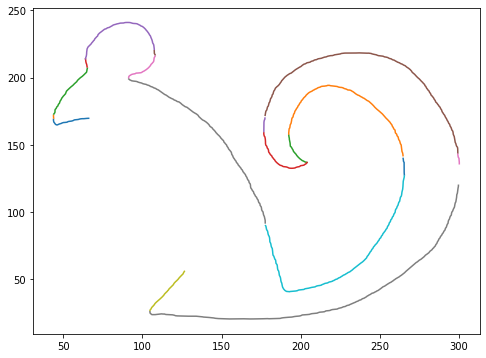

In [351]:
# Preliminary work on smoothing edges

def handle_micro_segments(line_segments, threshold):
    """
    Detects a series of adjacent micro-segments and connects
    them into one larger segment for spline interpolation.
    
    Threshold indicates the number of points that a segment
    must fall under for it to be deemed "too small."
    """
    result = []
    aggregate_segment_indices = []
    aggregation_mode = False
    small_segments = []
    for index, segment in enumerate(line_segments):
        size = segment.shape[0]
        if size < threshold:
            if not aggregation_mode:
                aggregation_mode = True
                # Grab the first item of the small segment
                first_small_point = segment[0]
                index_first_small_point = np.where(line_segments == first_small_point)
                for point in segment: 
                    small_segments.append(point)
            else:
                # Keep grabbing segments
                for point in segment:
                    small_segments.append(point)
        else:
            # This means that we need to start small_segment 
            # over again because we saw a huge chunk
            # So, reset aggregation mode
            if aggregation_mode:
                # Save a bookmark to where the "aggregate" indices are
                aggregate_segment_indices.append(len(result))
    
                # Now, we must look at the direction the small segments are going in, and
                # Toss out anything not also going in the same direction
                point_1 = small_segments[0]
                point_2 = small_segments[-1]
                increasing = (point_2[0] - point_1[0]) > 0
                
                filtered_small_segments = [small_segments[0]]
                for point in small_segments:
                    if increasing:
                        # If it's increasing, then check to see if the next point is smaller
                        if point[0] > filtered_small_segments[-1][0]:
                            filtered_small_segments.append(point)
                    else:
                        if point[0] < filtered_small_segments[-1][0]:
                            filtered_small_segments.append(point)
                result.append(np.array(filtered_small_segments))
                small_segments = []
                aggregation_mode = False
            result.append(segment)
    return (np.array(result), aggregate_segment_indices)
                

reduced_line_segments, aggregate_indices = handle_micro_segments(line_segments, 10)
# print(reduced_line_segments.shape)
# print(reduced_line_segments)
# import sys; sys.exit()
# TODO: remove tiny segments, and maybe add a third point to any particularly vertical lines
# We can now also process the direction that the lines are going in, figure out the direction of the tiny segments
# And then append them to either end if possible

plt.figure(figsize=(8, 6))
for line_segment in reduced_line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

print(f"We now reduce the number of line segments for this drawing from {len(line_segments)} to {len(reduced_line_segments)} segments total")